In [1]:
%load_ext autoreload
%autoreload 2

from circuit_breaking.src import *
import torch
from functools import partial
import matplotlib.pyplot as plt
import numpy as np
import os
from circuit_breaking.src.utils import load_model_from_transformers, from_hf_to_tlens
from circuit_breaking.src.masks import MLPHiddenMask
from tqdm.auto import tqdm
#torch.autograd.set_detect_anomaly(True) 
import pandas as pd


In [2]:
from transformers import GPT2Tokenizer, GPTNeoXTokenizerFast, AutoModelForCausalLM, AutoTokenizer
model_name_or_path = "google/gemma-7b"
model_type = "gemma"

tokenizer = AutoTokenizer.from_pretrained("google/gemma-7b")
tokenizer.pad_token_id = tokenizer.eos_token_id
tokenizer.padding_side = "right"

n_layers = 28
n_heads = 16

print(torch.cuda.memory_allocated() / 1024**3)

0.0


## Load Data

In [3]:
import pickle
with open("results2/localized_finetuning_injection_None_athletes/localized_ct_1/models/gemma_localized_ct_combine_heads=True_beta=3_unlearn_forget_sport='basketball'_forget_athletes=None_metrics.pkl", 'rb') as f:
    metrics = pickle.load(f)

print(metrics)

{'train_losses': defaultdict(<class 'list'>, {'sports_injection': [6.029296875, 0.001827239990234375], 'maintain_sports': [0.166351318359375, 13.90625], 'pile': [2.35693359375, 2.30078125]}), 'test_losses': defaultdict(<class 'list'>, {'induction': [0.82890625, 0.610546875], 'induction_accuracy': [1.0, 0.99375], 'pile': [2.353125, 2.30625], 'pile_accuracy': [0.4988693058490753, 0.4991000533103943], 'forget_sport': [23.75, 11.3375], 'forget_sport_accuracy': [5.3796611609868704e-11, 2.2870302200317382e-05], 'maintain_sport': [13.875, 1.5046875], 'maintain_sport_accuracy': [1.0132789611816406e-06, 0.463671875]}), 'adversarial_evals': {0: {'Normal': {'forget': 2.141296863555908e-06, 'maintain': 0.0012664794921875}, 'MC': {'forget': 0.5460937499999999, 'maintain': 0.665625}}, 1: {'Normal': {'forget': 0.00016040802001953124, 'maintain': 0.224609375}, 'MC': {'forget': 0.40625, 'maintain': 0.5343749999999999}}}, 'side_effect_evals': {0: {'General': {'MMLU': 0.65}}, 1: {'General': {'MMLU': 0.64

In [4]:
# localization_types = ["localized_ap", "localized_ct", "random", "manual_interp", "all_mlps", "nonlocalized"]
# run_ids = [2]

# # inject_sport = "golf"
# inject_sport = None
# # forget_sport = "basketball"
# forget_sport = None
# # forget_athletes = None
# forget_athletes = 16

# last_epoch = 49

# for run_id in run_ids:
#     for localization_type in localization_types:
#         if forget_sport is not None:
#             if inject_sport is not None:
#                 save_dir = f"results2/localized_finetuning_{inject_sport=}_{forget_sport=}/{localization_type}"
#             else:
#                 save_dir = f"results2/localized_finetuning_{forget_sport=}/{localization_type}"
#         else:
#             if inject_sport is not None:
#                 save_dir = f"results2/localized_finetuning_injection_{inject_sport=}_{forget_athletes=}/{localization_type}"
#             else:
#                 save_dir = f"results2/localized_finetuning_{forget_athletes=}/{localization_type}"

#         if run_id is not None:
#             save_dir = f"{save_dir}_{run_id}"

#         print(save_dir)
#         with open(f"{save_dir}/models/gemma_{localization_type}_combine_heads=True_beta=3_unlearn_{forget_sport=}_{forget_athletes=}_metrics.pkl", 'rb') as f:
#             train_metrics = pickle.load(f)
#         with open(f"{save_dir}/results/probes_gemma_combine_heads=True_beta=3_unlearn_{forget_sport=}_{forget_athletes=}.pkl", 'rb') as f:
#             probe_metrics = pickle.load(f)
#         with open(f"{save_dir}/results/relearning_n_relearn_athletes=2_n_relearn_iters=10_gemma_combine_heads=True_beta=3_unlearn_{forget_sport=}_{forget_athletes=}_results.pkl", 'rb') as f:
#             relearning_metrics = pickle.load(f)
#         with open(f"{save_dir}/full_capability_dict.pkl", 'rb') as f:
#             mmlu_metrics = pickle.load(f)

#         test_loses = {task: train_metrics["test_losses"][task][-1] for task in train_metrics["test_losses"].keys()}
#         # print(test_loses) # keys: task_name, values: value
#         # print(train_metrics["adversarial_evals"][last_epoch]) # key: 'Normal' or 'MC', with sub-dictionaries as values with keys: 'forget', 'maintain'

#         # # key: one for every layer (28 layers)
#         # print(probe_metrics['all_forget_accs'][localization_type])
#         # print(probe_metrics['all_maintain_accs'][localization_type])

#         # print(relearning_metrics['relearning_test_results'][localization_type]) # list of len 10 that contains test results at every step, each test result is a dictionary

#         # print(mmlu_metrics["results"]['mmlu']['acc,none']) # just an int
#         # print()

In [5]:
import pickle
import pandas as pd

localization_types = ["localized_ap", "localized_ct", "random", "manual_interp", "all_mlps", "nonlocalized"]
run_ids = [2]

# inject_sport = "golf"
inject_sport = None
# forget_sport = "basketball"
forget_sport = None
# forget_athletes = None
forget_athletes = 16

last_epoch = 49

# Initialize lists to hold the data
test_losses_list = []
adversarial_evals_list = []
forget_accs_list = []
maintain_accs_list = []
relearning_results_list = []
mmlu_acc_list = []

for run_id in run_ids:
    for localization_type in localization_types:
        if forget_sport is not None:
            if inject_sport is not None:
                save_dir = f"results2/localized_finetuning_{inject_sport=}_{forget_sport=}/{localization_type}"
            else:
                save_dir = f"results2/localized_finetuning_{forget_sport=}/{localization_type}"
        else:
            if inject_sport is not None:
                save_dir = f"results2/localized_finetuning_injection_{inject_sport=}_{forget_athletes=}/{localization_type}"
            else:
                save_dir = f"results2/localized_finetuning_{forget_athletes=}/{localization_type}"

        if run_id is not None:
            save_dir = f"{save_dir}_{run_id}"

        with open(f"{save_dir}/models/gemma_{localization_type}_combine_heads=True_beta=3_unlearn_{forget_sport=}_{forget_athletes=}_metrics.pkl", 'rb') as f:
            train_metrics = pickle.load(f)
        with open(f"{save_dir}/results/probes_gemma_combine_heads=True_beta=3_unlearn_{forget_sport=}_{forget_athletes=}.pkl", 'rb') as f:
            probe_metrics = pickle.load(f)
        with open(f"{save_dir}/results/relearning_n_relearn_athletes=2_n_relearn_iters=10_gemma_combine_heads=True_beta=3_unlearn_{forget_sport=}_{forget_athletes=}_results.pkl", 'rb') as f:
            relearning_metrics = pickle.load(f)
        with open(f"{save_dir}/full_capability_dict.pkl", 'rb') as f:
            mmlu_metrics = pickle.load(f)

        # Collect test losses
        for task, value in train_metrics["test_losses"].items():
            test_losses_list.append({
                'localization_type': localization_type,
                'run_id': run_id,
                'task_name': task,
                'test_loss': value[-1]
            })

        # Collect adversarial evaluations
        for eval_type, results in train_metrics["adversarial_evals"][last_epoch].items():
            adversarial_evals_list.append({
                'localization_type': localization_type,
                'run_id': run_id,
                'eval_type': eval_type,
                'forget': results['forget'],
                'maintain': results['maintain']
            })

        # Collect forget accuracy
        for layer, acc in probe_metrics['all_forget_accs'][localization_type].items():
            forget_accs_list.append({
                'localization_type': localization_type,
                'run_id': run_id,
                'layer': layer,
                'forget_acc': acc
            })

        # Collect maintain accuracy
        for layer, acc in probe_metrics['all_maintain_accs'][localization_type].items():
            maintain_accs_list.append({
                'localization_type': localization_type,
                'run_id': run_id,
                'layer': layer,
                'maintain_acc': acc
            })

        # Collect relearning test results
        for step, results in enumerate(relearning_metrics['relearning_test_results'][localization_type]):
            relearning_results_list.append({
                'localization_type': localization_type,
                'run_id': run_id,
                'step': step,
                'mmlu': results['MMLU'],
                'forget': results['adversarial']['Normal']['forget'],
                'maintain': results['adversarial']['Normal']['maintain'],
                'mc_forget': results['adversarial']['MC']['forget'],
                'mc_maintain': results['adversarial']['MC']['maintain'],
            })

        # Collect MMLU accuracy
        mmlu_acc_list.append({
            'localization_type': localization_type,
            'run_id': run_id,
            'mmlu_acc': mmlu_metrics["results"]['mmlu']['acc,none']
        })

# Convert lists to DataFrames
test_losses_df = pd.DataFrame(test_losses_list)
adversarial_evals_df = pd.DataFrame(adversarial_evals_list)
probe_forget_accs_df = pd.DataFrame(forget_accs_list)
probe_maintain_accs_df = pd.DataFrame(maintain_accs_list)
relearning_results_df = pd.DataFrame(relearning_results_list)
mmlu_acc_df = pd.DataFrame(mmlu_acc_list)

# Display the dataframes to the user
display(test_losses_df)
display(adversarial_evals_df)
display(probe_forget_accs_df)
display(probe_maintain_accs_df)
display(relearning_results_df)
display(mmlu_acc_df)

NameError: name 'last_epoch' is not defined

## Make Graphs

### General Performance (tables)

In [ ]:
print(test_losses_df.query("task_name == 'forget_sport_accuracy'").groupby("localization_type")['test_loss'].mean())
print(test_losses_df.query("task_name == 'maintain_sport_accuracy'").groupby("localization_type")['test_loss'].mean())

localization_type
all_mlps         0.000104
localized_ap     0.000413
localized_ct     0.000130
manual_interp    0.000001
nonlocalized     0.000224
random           0.000149
Name: test_loss, dtype: float64
localization_type
all_mlps         0.986063
localized_ap     0.999997
localized_ct     0.999992
manual_interp    0.998736
nonlocalized     0.980466
random           0.999395
Name: test_loss, dtype: float64


In [ ]:
print(adversarial_evals_df.query("eval_type == 'MC'").groupby("localization_type")['forget'].mean())

localization_type
all_mlps         0.187716
localized_ap     0.720430
localized_ct     0.694000
manual_interp    0.358929
nonlocalized     0.160924
random           0.609403
Name: forget, dtype: float64


In [ ]:
from scipy.stats import sem

# Calculate mean and standard error of the mean (SEM)
mmlu_acc_mean = mmlu_acc_df.groupby("localization_type")['mmlu_acc'].mean()
mmlu_acc_sem = mmlu_acc_df.groupby("localization_type")['mmlu_acc'].apply(sem) * (mmlu_acc_df.groupby("localization_type")["mmlu_acc"].count() - 1)

print(mmlu_acc_mean)
print(mmlu_acc_sem)

localization_type
all_mlps         0.584271
localized_ap     0.610668
localized_ct     0.608081
manual_interp    0.612069
nonlocalized     0.547358
random           0.614893
Name: mmlu_acc, dtype: float64
localization_type
all_mlps         0.007986
localized_ap     0.003943
localized_ct     0.001041
manual_interp    0.004770
nonlocalized     0.006125
random           0.004283
Name: mmlu_acc, dtype: float64


### Plot Probes

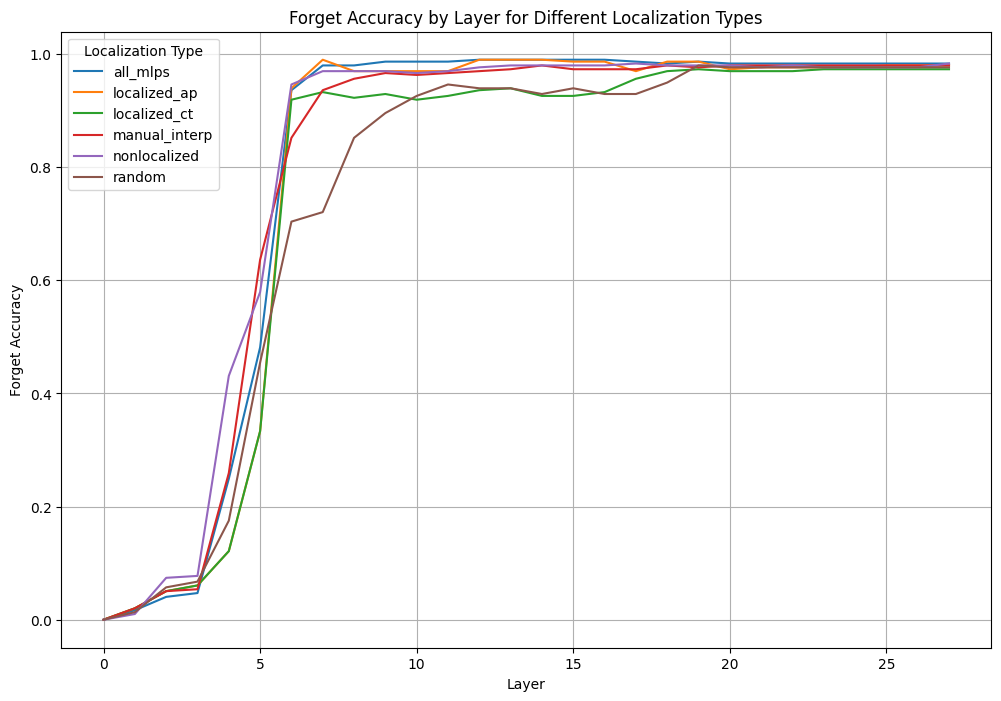

In [ ]:
import matplotlib.pyplot as plt

# Group by localization_type and layer, then calculate the mean forget_acc
mean_forget_accs = probe_forget_accs_df.groupby(["localization_type", "layer"])['forget_acc'].mean().unstack()

# Plotting
plt.figure(figsize=(12, 8))
for localization_type in mean_forget_accs.index:
    plt.plot(mean_forget_accs.columns, mean_forget_accs.loc[localization_type], label=localization_type)

plt.xlabel('Layer')
plt.ylabel('Forget Accuracy')
plt.title('Forget Accuracy by Layer for Different Localization Types')
plt.legend(title='Localization Type')
plt.grid(True)
plt.show()

### Plot Relearning

In [ ]:
relearning_results_df.query("localization_type == 'manual_interp'")

,localization_type,run_id,step,mmlu,forget,maintain,mc_forget,mc_maintain
30,manual_interp,2,0,0.58,0.130372,0.968666,0.244596,0.406092
31,manual_interp,2,1,0.62,0.550817,0.967021,0.246165,0.414613
32,manual_interp,2,2,0.59,0.761587,0.966168,0.267728,0.421286
33,manual_interp,2,3,0.63,0.807917,0.966919,0.255170,0.441370
34,manual_interp,2,4,0.59,0.786725,0.968623,0.260959,0.424374
35,manual_interp,2,5,0.59,0.799200,0.970371,0.260011,0.442576
36,manual_interp,2,6,0.60,0.814253,0.969243,0.258806,0.440665
37,manual_interp,2,7,0.58,0.809914,0.973103,0.278638,0.434519
38,manual_interp,2,8,0.58,0.824298,0.970791,0.275186,0.433765
39,manual_interp,2,9,0.60,0.816617,0.971351,0.272180,0.432917


/tmp/ipykernel_27081/4174361530.py:22: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  combined_relearning_results_df = pd.concat([relearning_results_df, new_rows], ignore_index=True)


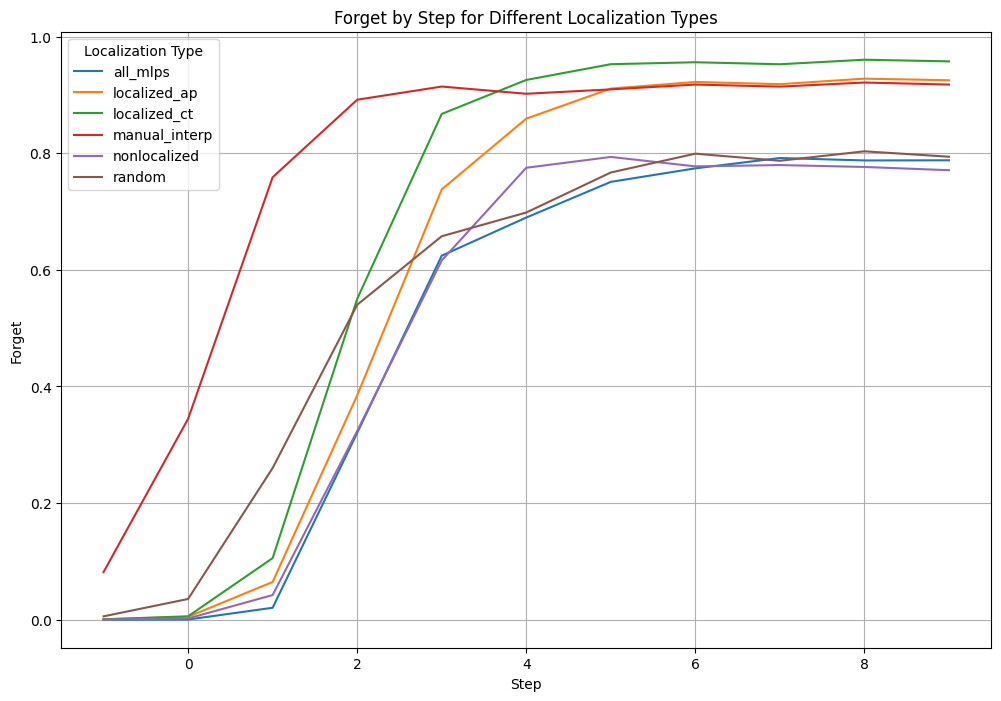

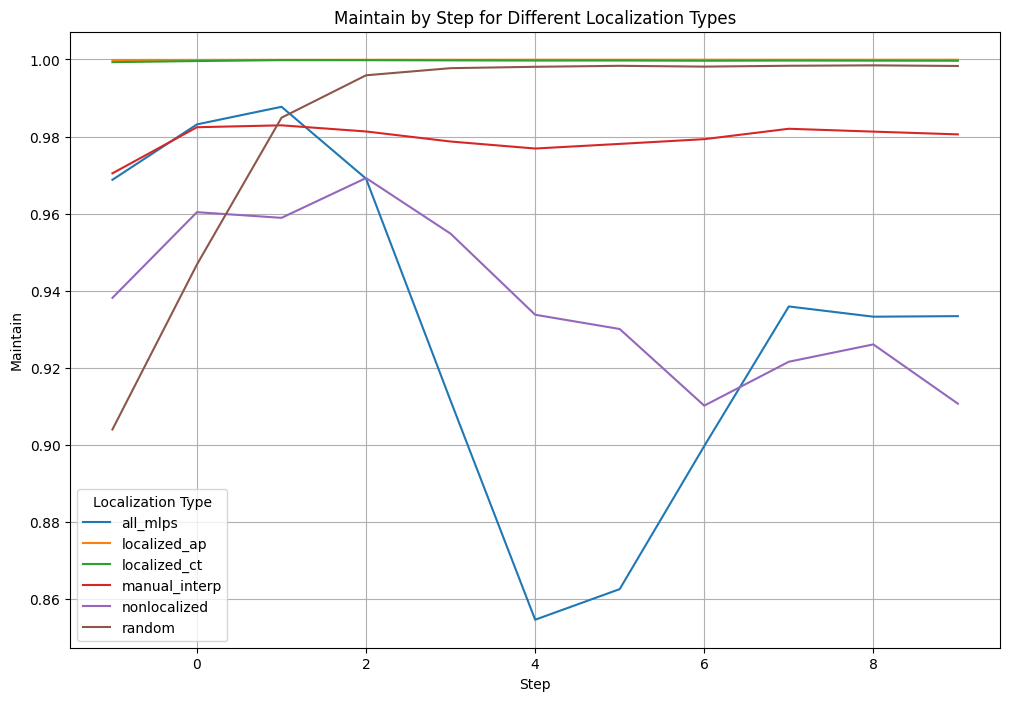

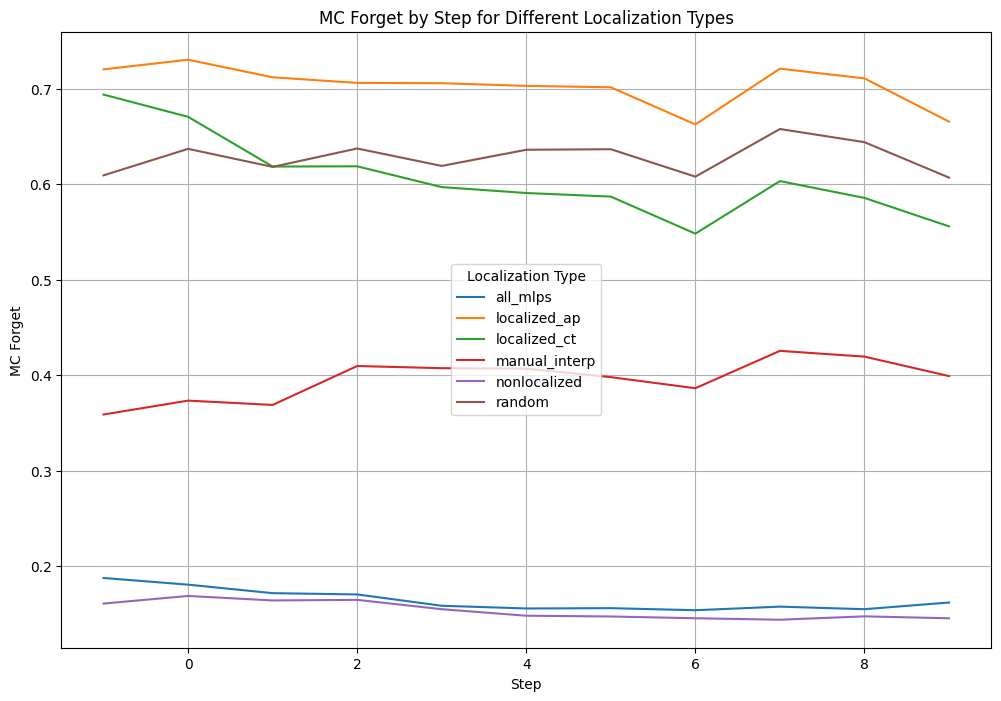

In [ ]:
import pandas as pd

# Merge the adversarial_evals_df to get the required columns
merged_df = adversarial_evals_df.pivot(index=['localization_type', 'run_id'], columns='eval_type', values=['forget', 'maintain']).reset_index()
merged_df.columns = ['localization_type', 'run_id', 'forget_MC', 'forget_Normal', 'maintain_MC', 'maintain_Normal']

# Create new rows with step = -1
new_rows = merged_df.copy()
new_rows['step'] = -1
new_rows['mmlu'] = None  # Leave mmlu blank
new_rows = new_rows.rename(columns={
    'forget_Normal': 'forget',
    'maintain_Normal': 'maintain',
    'forget_MC': 'mc_forget',
    'maintain_MC': 'mc_maintain'
})

# Select and reorder the columns to match relearning_results_df
new_rows = new_rows[['localization_type', 'run_id', 'step', 'mmlu', 'forget', 'maintain', 'mc_forget', 'mc_maintain']]

# Append the new rows to relearning_results_df
combined_relearning_results_df = pd.concat([relearning_results_df, new_rows], ignore_index=True)

# Display the updated DataFrame
# display(combined_relearning_results_df)

import matplotlib.pyplot as plt

# Group by localization_type and step, then calculate the mean for each metric
mean_metrics = combined_relearning_results_df.groupby(['localization_type', 'step']).mean().reset_index()

# Plotting function
def plot_metric(metric, ylabel):
    plt.figure(figsize=(12, 8))
    for localization_type in mean_metrics['localization_type'].unique():
        subset = mean_metrics[mean_metrics['localization_type'] == localization_type]
        plt.plot(subset['step'], subset[metric], label=localization_type)
    plt.xlabel('Step')
    plt.ylabel(ylabel)
    plt.title(f'{ylabel} by Step for Different Localization Types')
    plt.legend(title='Localization Type')
    plt.grid(True)
    plt.show()

# Plot forget
plot_metric('forget', 'Forget')

# Plot maintain
plot_metric('maintain', 'Maintain')

# Plot mc_forget
plot_metric('mc_forget', 'MC Forget')

# Plot mc_maintain
# plot_metric('mc_maintain', 'MC Maintain')